In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("/Users/joshlim/Documents/GitHub/BT4103-OPTIC/Data/Preprocessed_Dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247613 entries, 0 to 247612
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   OPERATION_ID              247613 non-null  float64
 1   LOCATION                  247613 non-null  object 
 2   ROOM                      247613 non-null  object 
 3   CASE_STATUS               247613 non-null  object 
 4   OPERATION_TYPE            247613 non-null  object 
 5   EMERGENCY_PRIORITY        247613 non-null  object 
 6   PATIENT_CODE              247613 non-null  object 
 7   SURGICAL_CODE             247613 non-null  object 
 8   DISCIPLINE                247613 non-null  object 
 9   SURGEON                   247613 non-null  object 
 10  ANAESTHETIST_TEAM         247613 non-null  object 
 11  ANAESTHETIST_MCR_NO       247613 non-null  object 
 12  ANESTHESIA                247613 non-null  object 
 13  EQUIPMENT                 247613 non-null  o

In [3]:
# Define features
target = 'ACTUAL_SURGERY_DURATION'

# Features to EXCLUDE
exclude_features = [
    'OPERATION_ID',  # Just an ID
    'PATIENT_CODE',  # Identifier (unless you want per-patient learning)
    'ACTUAL_SURGERY_DURATION',  # Target
    'ACTUAL_USAGE_DURATION',  # Likely data leakage - happens after surgery
    # Consider excluding these if they're post-surgery:
    'Delay_Reason',  # Check if this is known before surgery
    'Delay_Category',  # Check if this is known before surgery
]

feature_cols = [col for col in data.columns if col not in exclude_features]

categorical_features = [
    'LOCATION', 'ROOM', 'CASE_STATUS', 'OPERATION_TYPE', 
    'EMERGENCY_PRIORITY', 'SURGICAL_CODE', 'DISCIPLINE', 
    'SURGEON', 'ANAESTHETIST_TEAM', 'ANAESTHETIST_MCR_NO',
    'ANESTHESIA', 'EQUIPMENT', 'ADMISSION_STATUS',
    'ADMISSION_CLASS_TYPE', 'ADMISSION_TYPE', 'ADMISSION_WARD',
    'ADMISSION_BED', 'BLOOD', 'IMPLANT', 'DIAGNOSIS'
]

# Boolean features - convert to int
bool_features = ['AOH', 'CANCER_INDICATOR', 'TRAUMA_INDICATOR']
for col in bool_features:
    data[col] = data[col].astype(int)

X = data[feature_cols]
y = data[target]

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

In [5]:
# Create CatBoost Pool objects (more efficient)
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Baseline model
baseline_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MAE',  # More robust to outliers than RMSE
    eval_metric='MAE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

# Train
baseline_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    plot=True  # Shows training progress
)

# Evaluate
val_preds = baseline_model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_preds)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print(f"\nBaseline Performance:")
print(f"MAE: {val_mae:.2f} minutes")
print(f"RMSE: {val_rmse:.2f} minutes")
print(f"R²: {val_r2:.4f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 33.0303567	test: 32.7317008	best: 32.7317008 (0)	total: 192ms	remaining: 3m 12s
100:	learn: 15.3251524	test: 14.8431550	best: 14.8431550 (100)	total: 20.5s	remaining: 3m 2s
200:	learn: 14.7272306	test: 14.2581106	best: 14.2581106 (200)	total: 43.2s	remaining: 2m 51s
300:	learn: 14.5483245	test: 14.0982767	best: 14.0982767 (300)	total: 1m 6s	remaining: 2m 33s
400:	learn: 14.3592146	test: 13.9302283	best: 13.9302283 (400)	total: 1m 30s	remaining: 2m 15s
500:	learn: 14.2194428	test: 13.8148483	best: 13.8148483 (500)	total: 1m 54s	remaining: 1m 54s
600:	learn: 14.1274657	test: 13.7345751	best: 13.7345751 (600)	total: 2m 20s	remaining: 1m 32s
700:	learn: 14.0460946	test: 13.6636091	best: 13.6636091 (700)	total: 2m 45s	remaining: 1m 10s
800:	learn: 13.9765576	test: 13.6059701	best: 13.6059701 (800)	total: 3m 10s	remaining: 47.3s
900:	learn: 13.9209281	test: 13.5624538	best: 13.5624538 (900)	total: 3m 35s	remaining: 23.7s
999:	learn: 13.8759707	test: 13.5315409	best: 13.5315409 (999


Top 15 Most Important Features:
                     feature  importance
5              SURGICAL_CODE   35.842629
24    PLANNED_USAGE_DURATION   29.974864
23  PLANNED_SURGERY_DURATION   15.381077
10                ANESTHESIA    3.662795
7                    SURGEON    2.394106
14            ADMISSION_TYPE    2.326523
6                 DISCIPLINE    1.942830
15            ADMISSION_WARD    1.565126
4         EMERGENCY_PRIORITY    1.178915
2                CASE_STATUS    1.012174
1                       ROOM    0.976168
13      ADMISSION_CLASS_TYPE    0.877427
20                 DIAGNOSIS    0.610073
0                   LOCATION    0.601758
25              planned_hour    0.347778


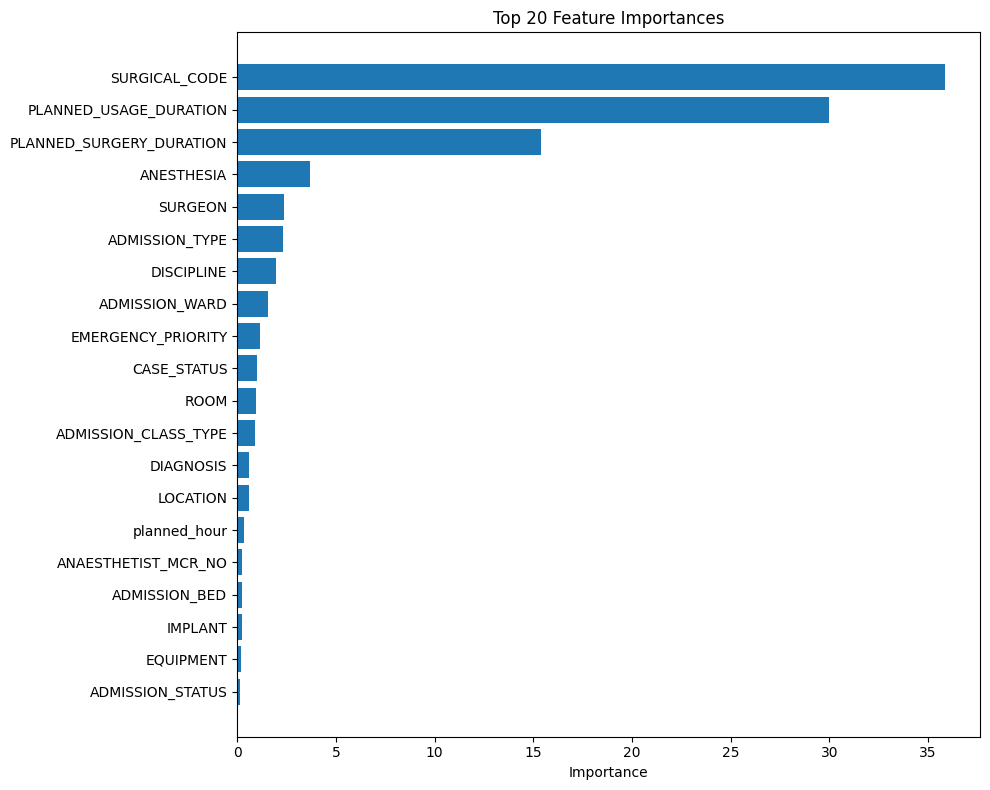

In [6]:
# Get feature importance
feature_importance = baseline_model.get_feature_importance(train_pool)
feature_names = X_train.columns

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(importance_df.head(15))

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(importance_df.head(20)['feature'], importance_df.head(20)['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Optional: Remove very low importance features
threshold = 0.1
important_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()

In [7]:
import optuna

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'MAE',
        'eval_metric': 'MAE',
        'random_seed': 42,
        'early_stopping_rounds': 50,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params)
    
    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True
    )
    
    val_preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, val_preds)
    
    return mae

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)  # Increase to 100-200 for better results

print("\nBest hyperparameters:")
print(study.best_params)
print(f"\nBest MAE: {study.best_value:.2f} minutes")

# Visualize optimization
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

[I 2025-10-27 01:36:55,040] A new study created in memory with name: no-name-68200052-0b43-42af-871c-473943e07e7d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-27 01:49:06,703] Trial 0 finished with value: 13.29835456960229 and parameters: {'iterations': 2997, 'depth': 6, 'learning_rate': 0.03496631536176837, 'l2_leaf_reg': 6.447908961714529, 'min_data_in_leaf': 100, 'random_strength': 2.5119741247542136, 'bagging_temperature': 0.7357125492073283, 'border_count': 202}. Best is trial 0 with value: 13.29835456960229.
[I 2025-10-27 01:53:56,355] Trial 1 finished with value: 13.39843223986189 and parameters: {'iterations': 825, 'depth': 8, 'learning_rate': 0.03436134318409719, 'l2_leaf_reg': 6.28440797507409, 'min_data_in_leaf': 80, 'random_strength': 1.7227402445577378, 'bagging_temperature': 0.06133032415308426, 'border_count': 202}. Best is trial 0 with value: 13.29835456960229.
[I 2025-10-27 02:00:37,307] Trial 2 finished with value: 13.552219521467114 and parameters: {'iterations': 2607, 'depth': 5, 'learning_rate': 0.016846444423095512, 'l2_leaf_reg': 4.453708557746639, 'min_data_in_leaf': 49, 'random_strength': 6.974966300269472

In [8]:
# Use best parameters from Optuna
best_params = study.best_params
best_params.update({
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'verbose': 100
})

final_model = CatBoostRegressor(**best_params)

# Train on train + val combined (optional, for final model)
# X_trainval = pd.concat([X_train, X_val])
# y_trainval = pd.concat([y_train, y_val])
# trainval_pool = Pool(X_trainval, y_trainval, cat_features=categorical_features)

final_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    plot=True
)

# Save model
final_model.save_model('best_surgery_duration_model.cbm')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 32.9003617	test: 32.5977310	best: 32.5977310 (0)	total: 114ms	remaining: 4m 40s
100:	learn: 15.2514840	test: 14.7706920	best: 14.7706920 (100)	total: 13s	remaining: 5m 2s
200:	learn: 14.6564305	test: 14.2276177	best: 14.2276177 (200)	total: 27.1s	remaining: 5m 3s
300:	learn: 14.3816128	test: 14.0097750	best: 14.0097742 (299)	total: 40.7s	remaining: 4m 50s
400:	learn: 14.0458994	test: 13.7604824	best: 13.7604824 (400)	total: 55.9s	remaining: 4m 45s
500:	learn: 13.7491578	test: 13.5591918	best: 13.5591918 (500)	total: 1m 12s	remaining: 4m 40s
600:	learn: 13.5569219	test: 13.4542245	best: 13.4542245 (600)	total: 1m 28s	remaining: 4m 31s
700:	learn: 13.4001044	test: 13.3852616	best: 13.3852616 (700)	total: 1m 44s	remaining: 4m 20s
800:	learn: 13.2941862	test: 13.3498287	best: 13.3497078 (798)	total: 2m 1s	remaining: 4m 8s
900:	learn: 13.2095108	test: 13.3245043	best: 13.3245043 (900)	total: 2m 17s	remaining: 3m 55s
1000:	learn: 13.1356159	test: 13.3035149	best: 13.3035149 (1000)	


FINAL TEST SET PERFORMANCE
MAE:  13.30 minutes
RMSE: 20.81 minutes
R²:   0.7862
MAPE: inf%

Error by Operation Type:
                error              
                 mean median  count
OPERATION_TYPE                     
Elective        12.55   6.80  42736
Emergency       17.96  11.97   6787

Error by Discipline:
                               error              
                                mean median  count
DISCIPLINE                                        
Anaesthesia                    12.43   8.57    120
Cardiac                        21.79  15.69   3726
CardiacThoracic&Vascular Surg  15.56   8.88   2778
Dental                         18.82  14.02    584
Gastroenterology & Hepatology   9.32   5.24   7147
Haematology - Oncology         21.94  24.69      6
Hand&Reconstructive Microsurg  16.59  10.77   2198
Medicine                       12.49   7.55    682
Obstetrics & Gynaecology        9.66   4.83   4751
Ophthalmology                   8.79   4.05   4363
Orthopaedic Surge

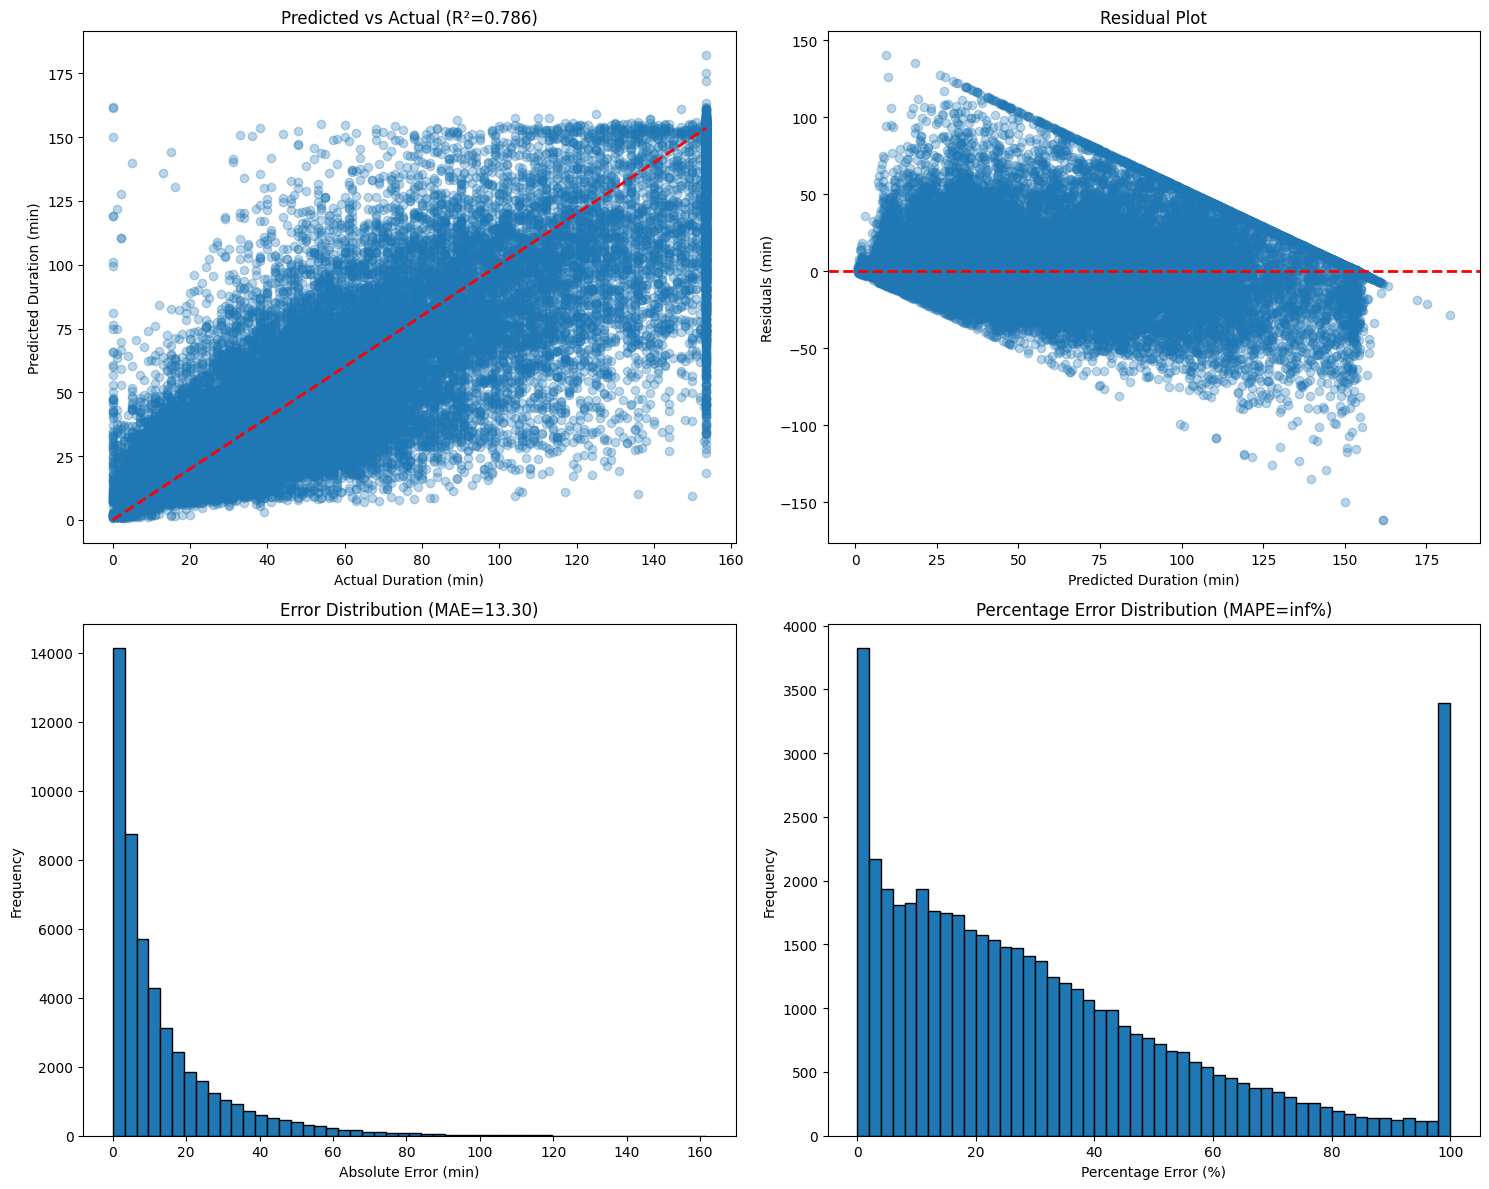

In [9]:
# Predictions
test_preds = final_model.predict(X_test)

# Overall metrics
test_mae = mean_absolute_error(y_test, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
test_mape = np.mean(np.abs((y_test - test_preds) / y_test)) * 100

print(f"\n{'='*50}")
print(f"FINAL TEST SET PERFORMANCE")
print(f"{'='*50}")
print(f"MAE:  {test_mae:.2f} minutes")
print(f"RMSE: {test_rmse:.2f} minutes")
print(f"R²:   {test_r2:.4f}")
print(f"MAPE: {test_mape:.2f}%")

# Error analysis by segments
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': test_preds,
    'error': np.abs(y_test - test_preds),
    'pct_error': np.abs((y_test - test_preds) / y_test) * 100
})

# Add categorical features for analysis
for cat_col in ['OPERATION_TYPE', 'DISCIPLINE', 'EMERGENCY_PRIORITY']:
    if cat_col in X_test.columns:
        results_df[cat_col] = X_test[cat_col].values

# Error by operation type
print("\nError by Operation Type:")
print(results_df.groupby('OPERATION_TYPE').agg({
    'error': ['mean', 'median', 'count']
}).round(2))

# Error by discipline
print("\nError by Discipline:")
print(results_df.groupby('DISCIPLINE').agg({
    'error': ['mean', 'median', 'count']
}).round(2))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_test, test_preds, alpha=0.3)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Duration (min)')
axes[0, 0].set_ylabel('Predicted Duration (min)')
axes[0, 0].set_title(f'Predicted vs Actual (R²={test_r2:.3f})')

# 2. Residual plot
residuals = y_test - test_preds
axes[0, 1].scatter(test_preds, residuals, alpha=0.3)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Duration (min)')
axes[0, 1].set_ylabel('Residuals (min)')
axes[0, 1].set_title('Residual Plot')

# 3. Error distribution
axes[1, 0].hist(results_df['error'], bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Absolute Error (min)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Error Distribution (MAE={test_mae:.2f})')

# 4. Percentage error distribution
axes[1, 1].hist(results_df['pct_error'].clip(0, 100), bins=50, edgecolor='black')
axes[1, 1].set_xlabel('Percentage Error (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Percentage Error Distribution (MAPE={test_mape:.2f}%)')

plt.tight_layout()
plt.show()

0:	learn: 0.7838875	test: 0.7822396	best: 0.7822396 (0)	total: 131ms	remaining: 5m 20s
100:	learn: 0.3805680	test: 0.3735128	best: 0.3735128 (100)	total: 12.8s	remaining: 4m 56s
200:	learn: 0.3643040	test: 0.3583989	best: 0.3583989 (200)	total: 26.1s	remaining: 4m 51s
300:	learn: 0.3589157	test: 0.3540657	best: 0.3540657 (300)	total: 39.8s	remaining: 4m 44s
400:	learn: 0.3513763	test: 0.3480600	best: 0.3480600 (400)	total: 55.7s	remaining: 4m 44s
500:	learn: 0.3442059	test: 0.3429513	best: 0.3429513 (500)	total: 1m 11s	remaining: 4m 38s
600:	learn: 0.3401019	test: 0.3405336	best: 0.3405336 (600)	total: 1m 27s	remaining: 4m 29s
700:	learn: 0.3369812	test: 0.3390660	best: 0.3390660 (700)	total: 1m 44s	remaining: 4m 19s
800:	learn: 0.3345073	test: 0.3381989	best: 0.3381989 (800)	total: 2m	remaining: 4m 7s
900:	learn: 0.3321095	test: 0.3374632	best: 0.3374632 (900)	total: 2m 17s	remaining: 3m 55s
1000:	learn: 0.3300604	test: 0.3368879	best: 0.3368851 (999)	total: 2m 33s	remaining: 3m 41s
1

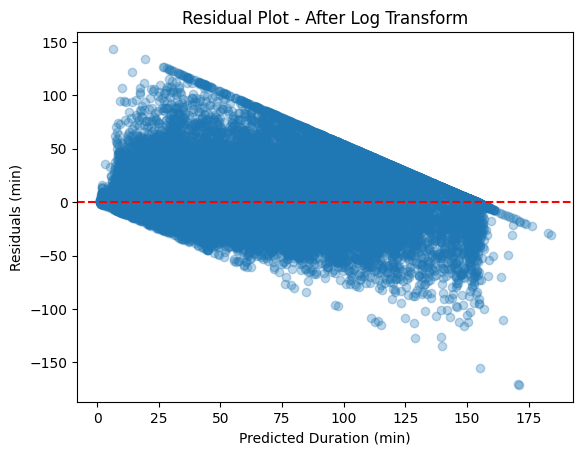

In [12]:
# TEST 1: Log transform (5 minutes)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

model_log = CatBoostRegressor(**best_params)
train_pool_log = Pool(X_train, y_train_log, cat_features=categorical_features)
val_pool_log = Pool(X_val, y_val_log, cat_features=categorical_features)

model_log.fit(train_pool_log, eval_set=val_pool_log)

test_preds_log = np.expm1(model_log.predict(X_test))
print(f"Original MAE: {test_mae:.2f}")
print(f"Log-transform MAE: {mean_absolute_error(y_test, test_preds_log):.2f}")

# Plot new residuals
residuals_new = y_test - test_preds_log
plt.scatter(test_preds_log, residuals_new, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Duration (min)')
plt.ylabel('Residuals (min)')
plt.title('Residual Plot - After Log Transform')
plt.show()

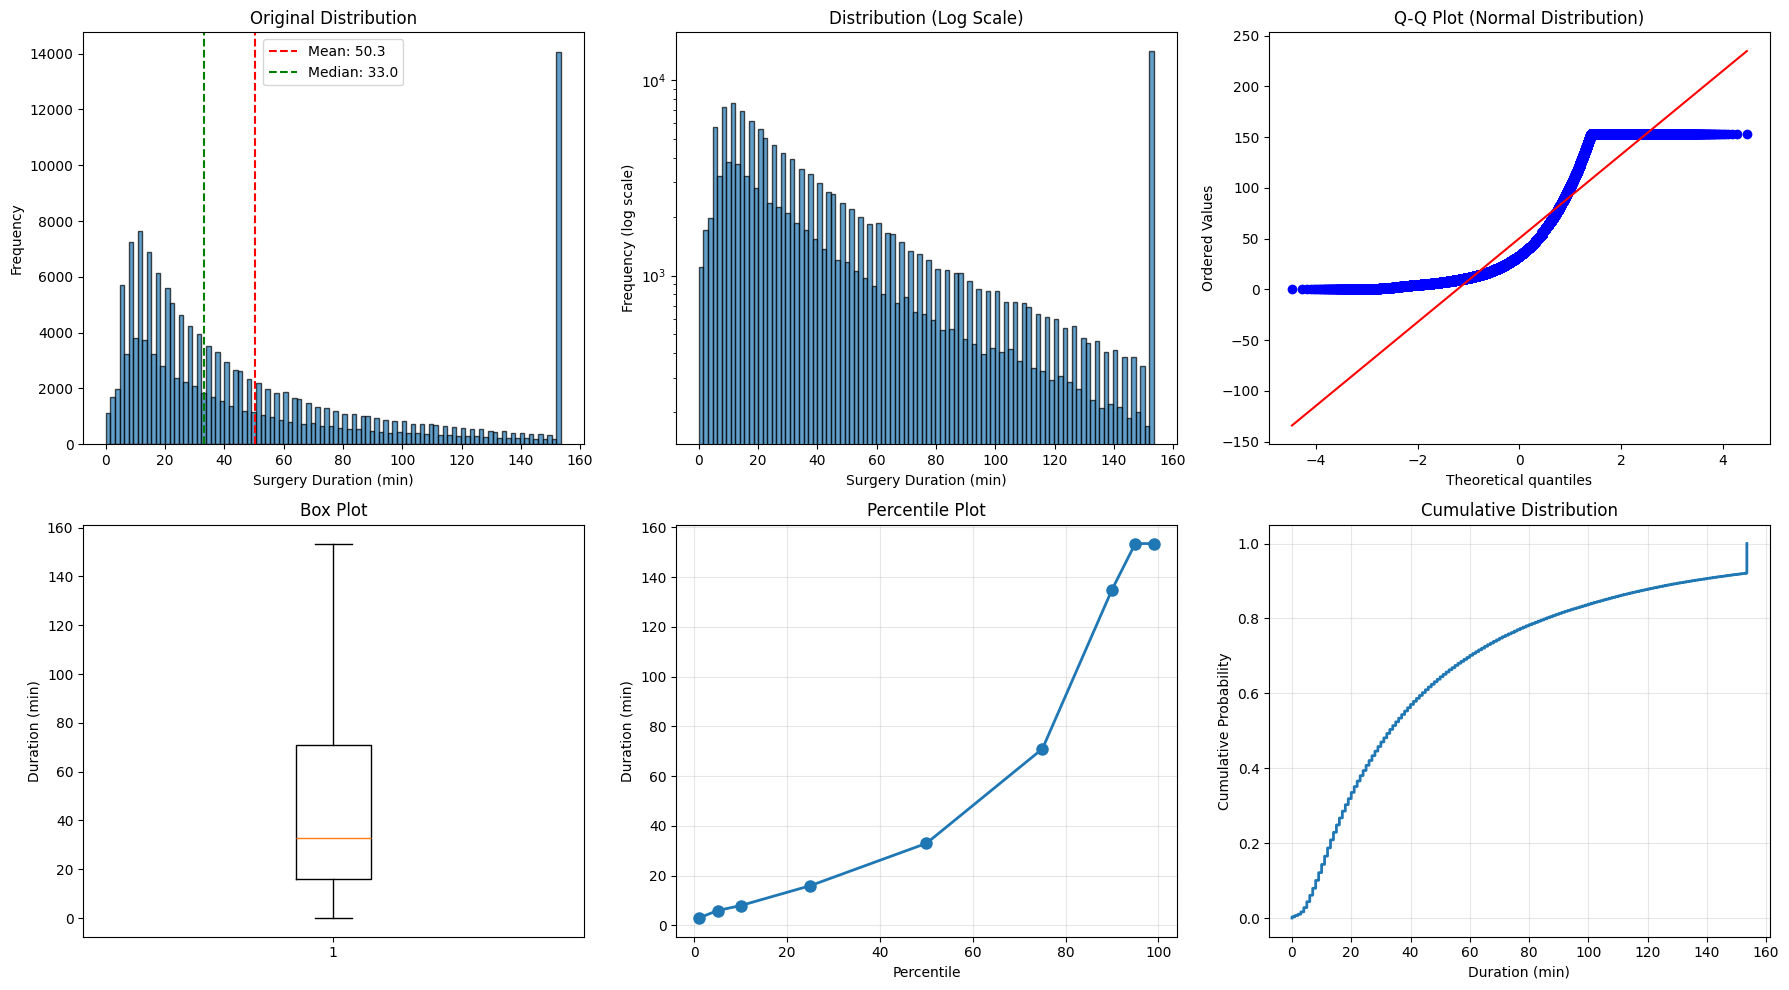

TARGET VARIABLE STATISTICS
Count:    173,328
Mean:     50.31 min
Median:   33.00 min
Std Dev:  45.22 min
Min:      0.00 min
Max:      153.50 min

Skewness: 1.128
Kurtosis: 0.103

Percentiles:
 1th:    3.0 min
 5th:    6.0 min
10th:    8.0 min
25th:   16.0 min
50th:   33.0 min
75th:   71.0 min
90th:  135.0 min
95th:  153.5 min
99th:  153.5 min

IQR-based outliers: 0 (0.0%)
  Lower bound: -66.5 min
  Upper bound: 153.5 min

ERROR ANALYSIS BY DURATION RANGE


NameError: name 'test_preds_original' is not defined

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ============================================
# 1. ANALYZE TARGET DISTRIBUTION
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Original distribution
axes[0, 0].hist(y_train, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Surgery Duration (min)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Original Distribution')
axes[0, 0].axvline(y_train.mean(), color='r', linestyle='--', label=f'Mean: {y_train.mean():.1f}')
axes[0, 0].axvline(y_train.median(), color='g', linestyle='--', label=f'Median: {y_train.median():.1f}')
axes[0, 0].legend()

# Log scale
axes[0, 1].hist(y_train, bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Surgery Duration (min)')
axes[0, 1].set_ylabel('Frequency (log scale)')
axes[0, 1].set_title('Distribution (Log Scale)')
axes[0, 1].set_yscale('log')

# QQ plot
stats.probplot(y_train, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot (Normal Distribution)')

# Box plot
axes[1, 0].boxplot(y_train, vert=True)
axes[1, 0].set_ylabel('Duration (min)')
axes[1, 0].set_title('Box Plot')

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
pct_values = [y_train.quantile(p/100) for p in percentiles]
axes[1, 1].plot(percentiles, pct_values, marker='o', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Percentile')
axes[1, 1].set_ylabel('Duration (min)')
axes[1, 1].set_title('Percentile Plot')
axes[1, 1].grid(True, alpha=0.3)

# Cumulative distribution
sorted_durations = np.sort(y_train)
cumulative = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)
axes[1, 2].plot(sorted_durations, cumulative, linewidth=2)
axes[1, 2].set_xlabel('Duration (min)')
axes[1, 2].set_ylabel('Cumulative Probability')
axes[1, 2].set_title('Cumulative Distribution')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("="*60)
print("TARGET VARIABLE STATISTICS")
print("="*60)
print(f"Count:    {len(y_train):,}")
print(f"Mean:     {y_train.mean():.2f} min")
print(f"Median:   {y_train.median():.2f} min")
print(f"Std Dev:  {y_train.std():.2f} min")
print(f"Min:      {y_train.min():.2f} min")
print(f"Max:      {y_train.max():.2f} min")
print(f"\nSkewness: {y_train.skew():.3f}")
print(f"Kurtosis: {y_train.kurtosis():.3f}")

print("\nPercentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"{p:2d}th: {y_train.quantile(p/100):6.1f} min")

# Check for outliers
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((y_train < lower_bound) | (y_train > upper_bound)).sum()
print(f"\nIQR-based outliers: {outliers:,} ({outliers/len(y_train)*100:.1f}%)")
print(f"  Lower bound: {lower_bound:.1f} min")
print(f"  Upper bound: {upper_bound:.1f} min")


# ============================================
# 2. ANALYZE PREDICTIONS BY DURATION RANGE
# ============================================

print("\n" + "="*60)
print("ERROR ANALYSIS BY DURATION RANGE")
print("="*60)

# Use your ORIGINAL model predictions (before log transform)
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': test_preds_original,  # Your original model predictions
    'error': y_test - test_preds_original,
    'abs_error': np.abs(y_test - test_preds_original),
    'pct_error': np.abs((y_test - test_preds_original) / y_test) * 100
})

# Create duration bins
bins = [0, 30, 60, 90, 120, 150, 180, np.inf]
labels = ['0-30', '30-60', '60-90', '90-120', '120-150', '150-180', '180+']
results_df['duration_range'] = pd.cut(results_df['actual'], bins=bins, labels=labels)

# Analysis by range
range_analysis = results_df.groupby('duration_range').agg({
    'abs_error': ['mean', 'median', 'std'],
    'error': 'mean',  # Mean signed error (shows bias)
    'pct_error': 'mean',
    'actual': 'count'
}).round(2)

range_analysis.columns = ['MAE', 'Median Error', 'Std Error', 'Bias', 'MAPE', 'Count']
print(range_analysis)

# Visualize bias by range
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(range_analysis)), range_analysis['MAE'], alpha=0.7)
plt.xlabel('Duration Range (min)')
plt.ylabel('Mean Absolute Error (min)')
plt.title('MAE by Surgery Duration Range')
plt.xticks(range(len(range_analysis)), range_analysis.index, rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
colors = ['red' if x > 0 else 'blue' for x in range_analysis['Bias']]
plt.bar(range(len(range_analysis)), range_analysis['Bias'], alpha=0.7, color=colors)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Duration Range (min)')
plt.ylabel('Bias (Actual - Predicted, min)')
plt.title('Prediction Bias by Duration Range\n(Positive = Underprediction)')
plt.xticks(range(len(range_analysis)), range_analysis.index, rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# ============================================
# 3. CHECK IF PLANNED_DURATION IS LEAKING
# ============================================

if 'PLANNED_SURGERY_DURATION' in X_train.columns:
    print("\n" + "="*60)
    print("PLANNED vs ACTUAL DURATION ANALYSIS")
    print("="*60)
    
    planned_vs_actual = pd.DataFrame({
        'planned': X_train['PLANNED_SURGERY_DURATION'],
        'actual': y_train
    })
    
    correlation = planned_vs_actual.corr().iloc[0, 1]
    print(f"Correlation between planned and actual: {correlation:.3f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(planned_vs_actual['planned'], planned_vs_actual['actual'], alpha=0.3, s=10)
    plt.plot([0, planned_vs_actual['planned'].max()], [0, planned_vs_actual['planned'].max()], 
             'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('Planned Duration (min)')
    plt.ylabel('Actual Duration (min)')
    plt.title(f'Planned vs Actual Duration (r={correlation:.3f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Analyze if model is just copying planned duration
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': final_model.get_feature_importance()
    }).sort_values('importance', ascending=False)
    
    planned_importance = feature_importance[
        feature_importance['feature'] == 'PLANNED_SURGERY_DURATION'
    ]
    
    if not planned_importance.empty:
        print(f"\nPLANNED_SURGERY_DURATION importance rank: "
              f"{planned_importance.index[0] + 1} / {len(feature_importance)}")
        print(f"Importance value: {planned_importance['importance'].values[0]:.2f}")